<img src='../00_common/figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Introduction to images
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>


## What you will learn in this tutorial
Images from imaging experiments are intensity values distributed in arrays. This tutorial focus on understanding what images and their graylevels are. 

- Terminal Training Objectives:
    - Obtain an awareness that numerical methods are needed for the quantitative interpretation of images.
    - Understand the concept of an image processing workflow.

- Enabling training objectives:
    - Understanding that the analysis objectives decide the choice of strategy and tools.
    - Basic definitions of 
        - images
        - gray levels
        - visibility
        
This tutorial gives you an entry point for more detailed tutorials.

#### Using the notebook
The cells in the notebook contain either executable python code or text. The cells are inteded to be executed in the order they appear and you can execute the code in a cell by pressing ctrl+enter or by clicking on the _Run_ button above. 

All code can be modified if you want to experiment with the code. Experimenting is even encouraged. It is always possible to get the original notebook from the repository if you would change the code too much.

The cells have been prepared in a manner that first demonstrates a concept and in some cases the needed plotting to show the result. The visualization is mostly not needed to understand at first, but it can give you some inspiration for your own future data visualization.


#### Before we start, we need to load some modules.
Python is a language that becomes powerful with the large number of modules that can be added. Each module has a specific purpose. The most important modules in this tutorial are ```numpy``` for mathmatical functions and numeric arrays and ```matplotlib``` for plotting data and showing images. A new module package in this tutorial is SciKit Image or ```skimage``` that provides image processing functions.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage.io import imread
from scipy.ndimage import convolve
from skimage.morphology import disk
from skimage.transform import resize
from itertools import product

import os
from io import StringIO
import skimage as ski

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline 

# The following code is a technical segment for better Colab integration.
import sys
if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf ImageProcessing
    !git clone https://github.com/ImagingELearning/ImageProcessing.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/ImageProcessing/tutorials/00_common/data/"
    sys.path.append("/content/scripts/python/")
    sys.path.append("/content/ImageProcessing/tutorials/00_common/")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

import readers as rd


# What shall we do with our images?

## You have data...

Imaging experiments produce large amounts of data

![Experiment data](figures/experimentdata.svg)

### Important questions

What is the purpose of the experiment?

- Qualitative visual analysis using 3D visualization
- Sample characterization
- Determine process parameters
- Count and measure size of features
- etc.



### Which information do you expect from the data


| Intensity  | Geometry |
|:----------|:----------|
| Material composition | Identify features |
| Material transport   | Volume |
| Physical quantities | Shape |

The information you want to quantify affects:
- The choice of processing method
- The experiment strategy 
- The choice of analysis tools


## Measurements are rarely perfect

<center>
<img src="figures/imperfect_imaging_system.svg" style="height:350px">
</center>

Relevant features versus:
- Resolution
- Sample movement
- Noise
- Inhomogeneous contrast
- Artefacts

## Initial questions
The analysis of images starts with asking yourself some basic questions
1. _Why_ did I get the image I see and why do I want to analyze it?
2. _How_ do I extract the correct information from the image?
3. _When_ was the data obtained and when do I need the results?

These questions should actually be asked several times starting even before the experiment as a cross check if you are on the right track. 


# Images

## Define an image

### What is an image?

A very abstract definition: 
- __A pairing between spatial information (position)__
- __and some other kind of information (value).__

In most cases this is a two- or three-dimensional position (x,y,z coordinates)

### Image sampling
| The world is | The computer needs|
|:---:|:---:|
| Continuous    | Discrete levels |
| No boundaries | Limited extent | 

A real world observation is contious and we need to sample the information in order to bring it into the computer for storage and to perform our analysis. There are different types of sampling involved to get a digital image. 

Intensity 
: The continous intensity must be sampled into discrete levels represented by a number of bits

Locations
:The location in the scene must be rasterized into a grid of pixels that contain the image intensity. The size of the pixels determine the greatest spatial frequency that can be respresented in the image. The spatial sampling follows the Nyquist sampling theorem that says that you have to sample by twice as fast the highest frequency in the scene. If you sample too slow you will see aliasing effects that appear as moiree fringes in the image.   

```{figure} figures/grid.pdf
---
scale: 75%
---
The real world is sampled into discrete images with limited extent.
```

<center>
<img src="figures/grid.svg" style="height:400px">
</center>

### Different types of images

<table>
    <tr>
        <th><center>2D</center></th>
        <th><center>3D</center></th>
        <th><center>4D</center></th>
    </tr>
    <tr>
        <td><img src="figures/plane_10x10.svg" style="height:50px"></td>
        <td><img src="figures/cube_10x10x10.svg" style="height:100px">
            <img src="figures/timeseries_visualization.svg" style="height:100px">
        </td>
        <td><img src="figures/4D-images.svg" style="height:100px"></td>
    </tr>
    <tr>
        <td>Radiographs</td>
        <td>Tomography<br/>Time-series<br/>Spectrum</td>
        <td>Volume time series</td>
    </tr>
</table>


## Pixel size and resolution 

It is important to distinguish between pixel size and resolution

### Pixel size
The pixel size is
- The sample pitch between two adjacent pixels
- The smallest area represented in the image

### Resolution 
The resolution is related to the optical system
- It is the effect of the optical transfer function of the acquisition system.
- Should have a greater value than the pixel size.
- Defines the smallest pixel size when you set up your acquistion conditions.


### Demonstrating different pixel sizes
What happens when we represent the same image with less pixels?

In this example we downsample the image first by a factor two. This change is barely visible when we show the image, but the number of pixels have reduced by a factor four. In the second example the image is downscaled by a factor 32 and you can clearly observe how pixelated the image is. A this level of downscaling, you can only see very coarse features in the sample.

Down scaling is sometimes used as a method to speed up the frame rate as it radiacally reduces the number of bytes to be transfered from the detector and also the amount of data to write on disk. You should however be careful not to down scale by a too great factor as you will loose spatial information when doing so.

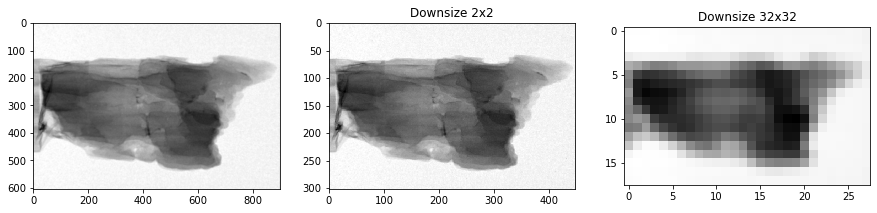

In [4]:
img=np.load('data/wood.npy');
fig,ax = plt.subplots(1,3, figsize=[15,5])
ax[0].imshow(img,cmap='gray'); plt.title('Original')

downsize =  2; 
resized  = resize(img,(img.shape[0] // downsize, img.shape[1] // downsize))
ax[1].imshow(resized, interpolation='None',cmap='gray'); ax[1].set_title('Downsize {0}x{0}'.format(downsize))

downsize = 32; 
resized  = resize(img,(img.shape[0] // downsize, img.shape[1] // downsize))
ax[2].imshow(resized,interpolation='None',cmap='gray'); ax[2].set_title('Downsize {0}x{0}'.format(downsize));

### Edges at different resolutions and pixel sizes

Finding the correct pixel size is related to the resolution of the imaging system. You can sample low resolved scenes with many pixels but then the edges will appear blurred and will essentially waste a lot data on little added value.

The example below shows what an ideal edge would look like and what it mostly looks like when we acquire our images. As you can see, the "real" edge is represented by a smooth transition spread over several pixels.

```{figure} figures/edge.pdf
---
scale: 75%
---
Examples of edges sampled with different pixel sizes.
```

<center>
<img src="figures/edges.svg" style="height:600px">
</center>

__Note__: Resolution and pixel size are important topics and have a dedicated set of tutorials to dive deeper into their details.

## Image intensity
What happens when we reduce the number of gray-levels in the image?

The image intensity is determined by the response function of the imaging system. In the case of neutron imaging we are talking about the transmission of the neutron beam through the sample. The transmission follows Beer-Lambert's law
$I(x,y)=I(x,y) e^{-\int_L \mu(x) dx}$, this is only a simplified version. More complicated versions including the neutron energy are presented in other parts of this course.

The information captured by the detector is stored in digital form with different gray level dynamics. We are often talking about 8 or 16 bit integer when we store images. This means that each pixel can represent the measured intensity with either 256 or 65565 gray levels respectively. In the example below we demonstrate what happens when only very few gray levels are used.

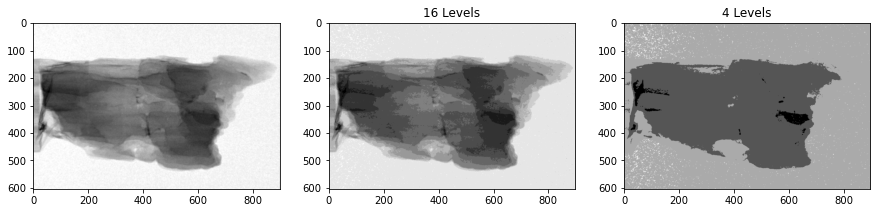

In [5]:
img=np.load('data/wood.npy');
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(img, cmap='gray'); plt.title('Original')

levels   = 16; 
lvl = np.floor(img*levels)
ax[1].imshow(lvl, cmap='gray'); ax[1].set_title('{0} Levels'.format(levels));

levels   = 4 ; 
lvl = np.floor(img*levels)
ax[2].imshow(lvl, cmap='gray'); ax[2].set_title('{0} Levels'.format(levels));

It is important to use as many gray levels at possible when you expose your images. The image turns patchy when you use too few levels which you can see in the example above. The patchiness reduces the precision of your evaluation, there is less margin to make estimations and decisions. The number of gray levels depend on many factors like:

- Exposure time
- Neutron flux
- Conversion efficiency
- Conversion rate of the detector
- Pixel size

So, it is your task to optimize your acquisition to provide well illuminated images by changing these parameters. Some are easier than others to change and contstraint are given by the type of investigation you are doing.

### How many bits are needed?

The number of bits you need depends on:
- Contrast difference
- Separate many different sample features
- Sensitivity to rounding errors

The table below gives you an idea how many bits you need to represent your image information. In the extreme you would only need a single bit per pixel (8 pixels per byte) to represent a bi-level image from a segmentation. The other extreme would be to use double precision floating point that requires 64 bits (8 bytes) per pixels. Double precision is rarely needed and single precision is mostly sufficient which saves you memory. Saving memory is in particular important when you work with 3D images.

<span style="font-size:1.5em;">

| Few bits | Many bits | Floating point |
|:----------|:-----------|:----------------|
|High contrast<br/>Clean images<br/>Segmented data|Low contrast<br/>Noisy images<br/>Gradual changes|High intensity dynamics<br/>Quantification to physical properties<br/>In algorithms|

</span>

### The histogram

The histogram is a statistical tool to show frequency of each graylevel in the image. 

It is essentially a plot where the you count how many times each gray level appears in the image. For a 16-bit image this would result 65565 points. This is far too detailed therefore it is common to use bins of several gray level to reduce the level of detail in the histogram and also improve the readability. In the example below we use 100 histogram bins which look quite reasonable for this image. Chosing the number of bins depends on the image size too. Your histogram doesn't look very useful if you have too many bins compared to the available number of pixels. You can use the piece of code below to explore what happens when you change the number of bins.

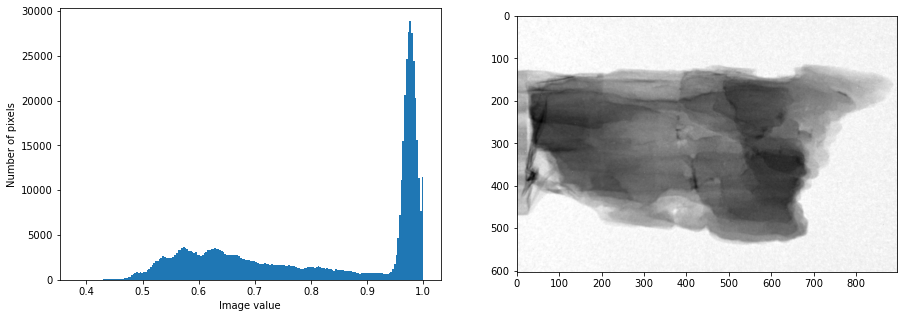

In [6]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# Compute and show a histogram
ax[0].hist(img.ravel(),bins=200)


ax[0].set_xlabel('Image value'), ax[0].set_ylabel('Number of pixels')
ax[1].imshow(img,cmap='gray');

It can be used for the analysis of the image as it gives you an idea which values are related to different features in the image. The histogram tells you the area covered by a give pixel value and a later section we will see how the histogram can be used to segment the images.

### Details of the histogram
Let's look att different regions in the image and their representation in the histogram.

<center>
<img src="figures/histogram_regions.svg" style="height:400px">
</center>


```{figure} figures/histogram_regions.pdf
---
scale: 75%
---
Regions in the image connected to their position in the histogram.
```


### Histogram examples

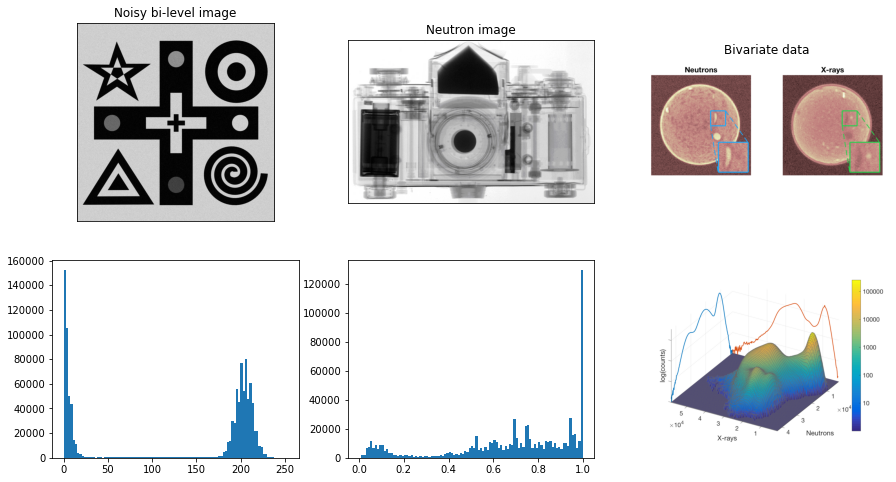

In [7]:
a=plt.imread('figures/testpattern_noisy.jpg')
b=plt.imread('figures/neutron_camera.png')
c0=plt.imread('figures/root_slices.png')
c1=plt.imread('figures/root_histogram.png')

fig,ax=plt.subplots(2,3,figsize=(15,8))
ax=ax.ravel()

ax[0].imshow(a,cmap='gray')
ax[0].set_xticks([]);ax[0].set_yticks([])
ax[0].set_title('Noisy bi-level image')
ax[3].hist(a.ravel(),bins=100)
ax[1].imshow(b,cmap='gray')
ax[1].set_title('Neutron image')
ax[1].set_xticks([]);ax[1].set_yticks([])
ax[4].hist(b.ravel(),bins=100)
ax[2].imshow(c0)
ax[2].set_title('Bivariate data')
ax[2].axis('off')
ax[5].imshow(c1)
ax[5].axis('off');

## Visualizing gray levels

The human eye is not able to resolve many intensity levels

In this example we demonstrate how easy or hard it can be to perceive contrast differences in an image with different number of gray levels. How well you can see the differences depends on one hand on how well your eye can resolve the contrast difference, but there are also technical issues related to how well you can see the changes. E.g. how well your screen can display the changes and even the ambient light in the room you are working in.

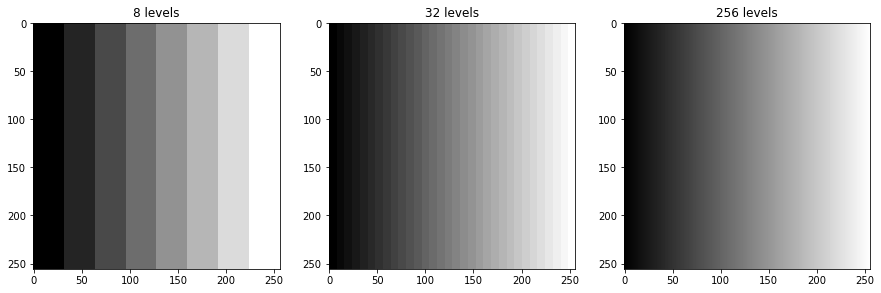

In [8]:
xlin = np.linspace(0,255, 256)
xx, yy = np.meshgrid(xlin, xlin)

fig, ax = plt.subplots(1,3, figsize = (15, 5))
n=32; ax[0].imshow(np.floor(xx/n), interpolation='None', cmap = 'gray');  ax[0].set_title('{0} levels'.format(256//n))
n=8;  ax[1].imshow(np.floor(xx/n), interpolation='None', cmap = 'gray');  ax[1].set_title('{0} levels'.format(256//n))
n=1;  ax[2].imshow(np.floor(xx/n), interpolation='None', cmap = 'gray');  ax[2].set_title('{0} levels'.format(256//n));

### Using pseudo colormaps

The image intensity is mostly only represented by a scalar by a gray level. Which is makes it hard to see subtle changes in intensity. Colormaps can help here.

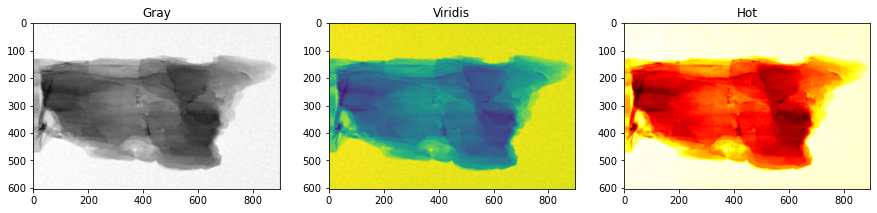

In [9]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img,cmap='gray');    ax[0].set_title('Gray')
ax[1].imshow(img,cmap='viridis'); ax[1].set_title('Viridis')
ax[2].imshow(img,cmap='hot');     ax[2].set_title('Hot');

Colormaps are only used for the visulization making it possible to better visualize and highlight features in the image. They can however also be misleading if you chose the wrong colormap. The interpretation of the image is in particular hard when you start manipulating the colormap. In this way it is even posible to "invent" features in the image that are not real. A typical example is that you thanks to the colormap could see a denser skin like structure near the sample boundary. It the reality this "skin" is only the smooth edge which is caused by low resolution of the imaging system.

### Brightness
With image brightness, you can focus on narrow gray level intervals to better visually resolve local details.

<center>
<img src="figures/histogram_brightness.svg" style="height:500px">
</center>

```{figure} figures/histogram_brightness.pdf
---
scale: 75%
---
Narrow intensity intervals to highlight low (left) and high (right) graylevel regions.
```


### Contrast

Contrast controls the width of the intensity interval to use.

<center>
<img src="figures/histogram_contrast.svg" style="height:500px">
</center>

Contrast control is often used to define which gray levels to include when you save image to file. The image is usually represented in floating point data format after some calculations and you have to limit the interval to resolve the relevant information with many gray levels and reject outliers when you convert to 8- or 16-bit integers. 

The example shows a narrow interval that mostly is useful to highlight features with small difference in contrast. The example with wider interval would is set to reject the background while most of the sample is visible. This setting may be useful for presentationations and publication where you want to boost the visibility, but is not recommended if you want to use the image in further calculations. In the latter case it is important to keep as many gray levels as possible, i.e. also include the noise flucuations in the background.

```{figure} figures/histogram_contrast.pdf
---
scale: 75%
---
Different image contrasts. Narrow interval to the left and wide interval to the right.
```


## Pixelwise operations

Pixelwise operations apply scalar operations to each pixel.
- Arithmetics +, -, *, /
- Functions e.g. sin(x), exp(x), ln(x)

Statistic functions
- mean, standard deviation
- min, max

### Demonstrating arithmetic functions (flat field normalization)

$$normed = \frac{img-dc}{ob-dc}$$

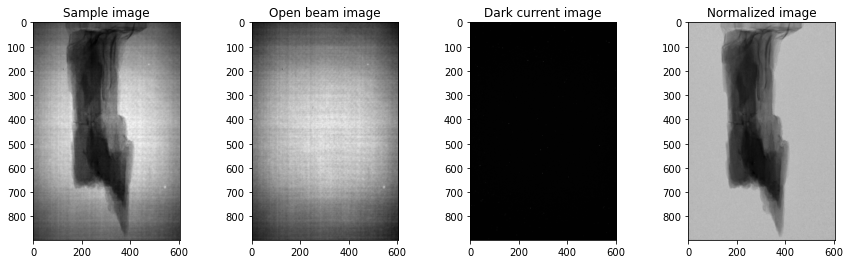

In [10]:
img = plt.imread('data/wood_0000.tif')
ob  = plt.imread('data/ob_0000.tif')
dc  = plt.imread('data/dc_0000.tif')

normed = (img-dc)/(ob-dc)

fig,ax = plt.subplots(1,4,figsize=(15,4))
ax[0].imshow(img,    cmap='gray'); ax[0].set_title('Sample image')
ax[1].imshow(ob,     cmap='gray'); ax[1].set_title('Open beam image')
ax[2].imshow(dc,     cmap='gray'); ax[2].set_title('Dark current image')
ax[3].imshow(normed, cmap='gray'); ax[3].set_title('Normalized image');

### Normalization with loops
Pixel wise operations can also be implemented using loops. This results in more complicated code and is mostly less efficent in python.

In [11]:
normed = np.zeros(img.shape)

for r in range(img.shape[0]):
    for c in range(img.shape[1]):
        normed[r,c]=(img[r,c]-dc[r,c])/(ob[r,c]-dc[r,c])

## Questions
1. How many gray levels can the human eye percieve? Try to find your limit using the code.
2. What does the histogram tell you about an image?

# Summary 

In this lecture you learned about:
1. Images and pixels.
2. Gray level dynamics and how to visualize them.
2. The histogram.